In [320]:
# 셀에서 값을 모두 출력
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import Image

In [321]:
import os
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import datetime
import re

from sklearn.cluster import KMeans

In [322]:
def pd_print(x):
    pd.set_option('display.max_rows', None)
    display(x)
    pd.set_option('display.max_rows', 20)
    
def np_print(x):
    np.set_printoptions(threshold=np.inf)
    display(x)
    np.set_printoptions(threshold=10)

In [323]:
import warnings

pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option("display.float", "{:.1f}".format)
warnings.filterwarnings(action='ignore')

In [324]:
# 한글폰트적용
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)
%config InlineBackend.figure_format = 'retina'

In [67]:
os.chdir('C:/Users/wxc03/Desktop/개인작업/온라인 리테일')

In [325]:
os.chdir('D:/Dropbox/DataScience/Projects/온라인 리테일')

# 데이터 로드

In [499]:
retail = pd.read_csv('online_retail.csv')

In [8]:
retail.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,7,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,7,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,7,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1,13085,United Kingdom


In [124]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


# 1. 데이터 클리닝

## 1.1. 결측치 처리

전체 데이터 레코드 1,067,370 개 중 Customer ID 데이터가 없는 243,007 개의 레코드는 제거하였음.

In [506]:
retail = retail[retail['Customer ID'].notna()]

## 1.2. 중복 데이터 처리

동일한 레코드가 다수 발견되어 이를 처리하였음.

In [8]:
print('중복 데이터 레코드 수: {:,} 개'.format(retail.duplicated().sum()))

중복 데이터 레코드 수: 26,479 개


In [507]:
retail.drop_duplicates(inplace=True)

## 1.3. Stock Code 전처리

Stock Code 변수를 탐색하는 과정에서 제품 코드가 아닌 코드들을 일부 발견하였음. 이는 고객의 주문 데이터는 무관하다고 판단하여 해당 되는 데이터는 제거하였음.

In [508]:
no_stock_code = retail[retail['StockCode'].str.contains('^[a-zA-Z]', regex=True)]['StockCode'].unique()
no_stock_code

array(['POST', 'D', 'M', 'C2', 'BANK CHARGES', 'TEST001', 'TEST002',
       'PADS', 'ADJUST', 'ADJUST2', 'SP1002', 'DOT', 'CRUK'], dtype=object)

In [500]:
retail[retail['StockCode'].isin(no_stock_code)].head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
89,489439,POST,POSTAGE,3,2009-12-01 09:28:00,18.0,12682.0,France
126,489444,POST,POSTAGE,1,2009-12-01 09:55:00,141.0,12636.0,USA
173,489447,POST,POSTAGE,1,2009-12-01 10:10:00,130.0,12362.0,Belgium
625,489526,POST,POSTAGE,6,2009-12-01 11:50:00,18.0,12533.0,Germany
735,C489535,D,Discount,-1,2009-12-01 12:11:00,9.0,15299.0,United Kingdom


In [509]:
retail = retail[~retail['StockCode'].isin(no_stock_code)].reset_index(drop=True)

## 1.4. 취소된 주문 제거

데이터 탐색 과정에서 주문이 취소된 구매 이력을 발견하여 취소된 주문은 모두 제거하였음.
 - 취소된 주문의 경우 Quantity(구매 수량)이 음수로 표시되며, Invoice에서 앞에 C(Cancelled)가 표기되어있음

In [165]:
retail[retail['Quantity']<0].head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
175,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,3,16321,Australia
176,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,2,16321,Australia
177,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4,16321,Australia
178,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2,16321,Australia
179,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,3,16321,Australia


In [510]:
retail = retail[retail['Quantity']>0].reset_index(drop=True)

# 2. 구매 패턴 분석

In [511]:
pattern_df = retail.copy()
pattern_df['InvoiceDate'] = pd.to_datetime(pattern_df['InvoiceDate'])

## 2.1. 일일 주문량 추이

In [512]:
pattern_df['InvoiceDate_day'] = pattern_df['InvoiceDate'].dt.date

In [15]:
daily_cnt = pattern_df.groupby('InvoiceDate_day')['Invoice'].nunique()

# Smooth line plot
daily_cnt_smooth = daily_cnt.rolling(7).mean()

In [113]:
from datetime import datetime, timedelta
from matplotlib.patches import Rectangle

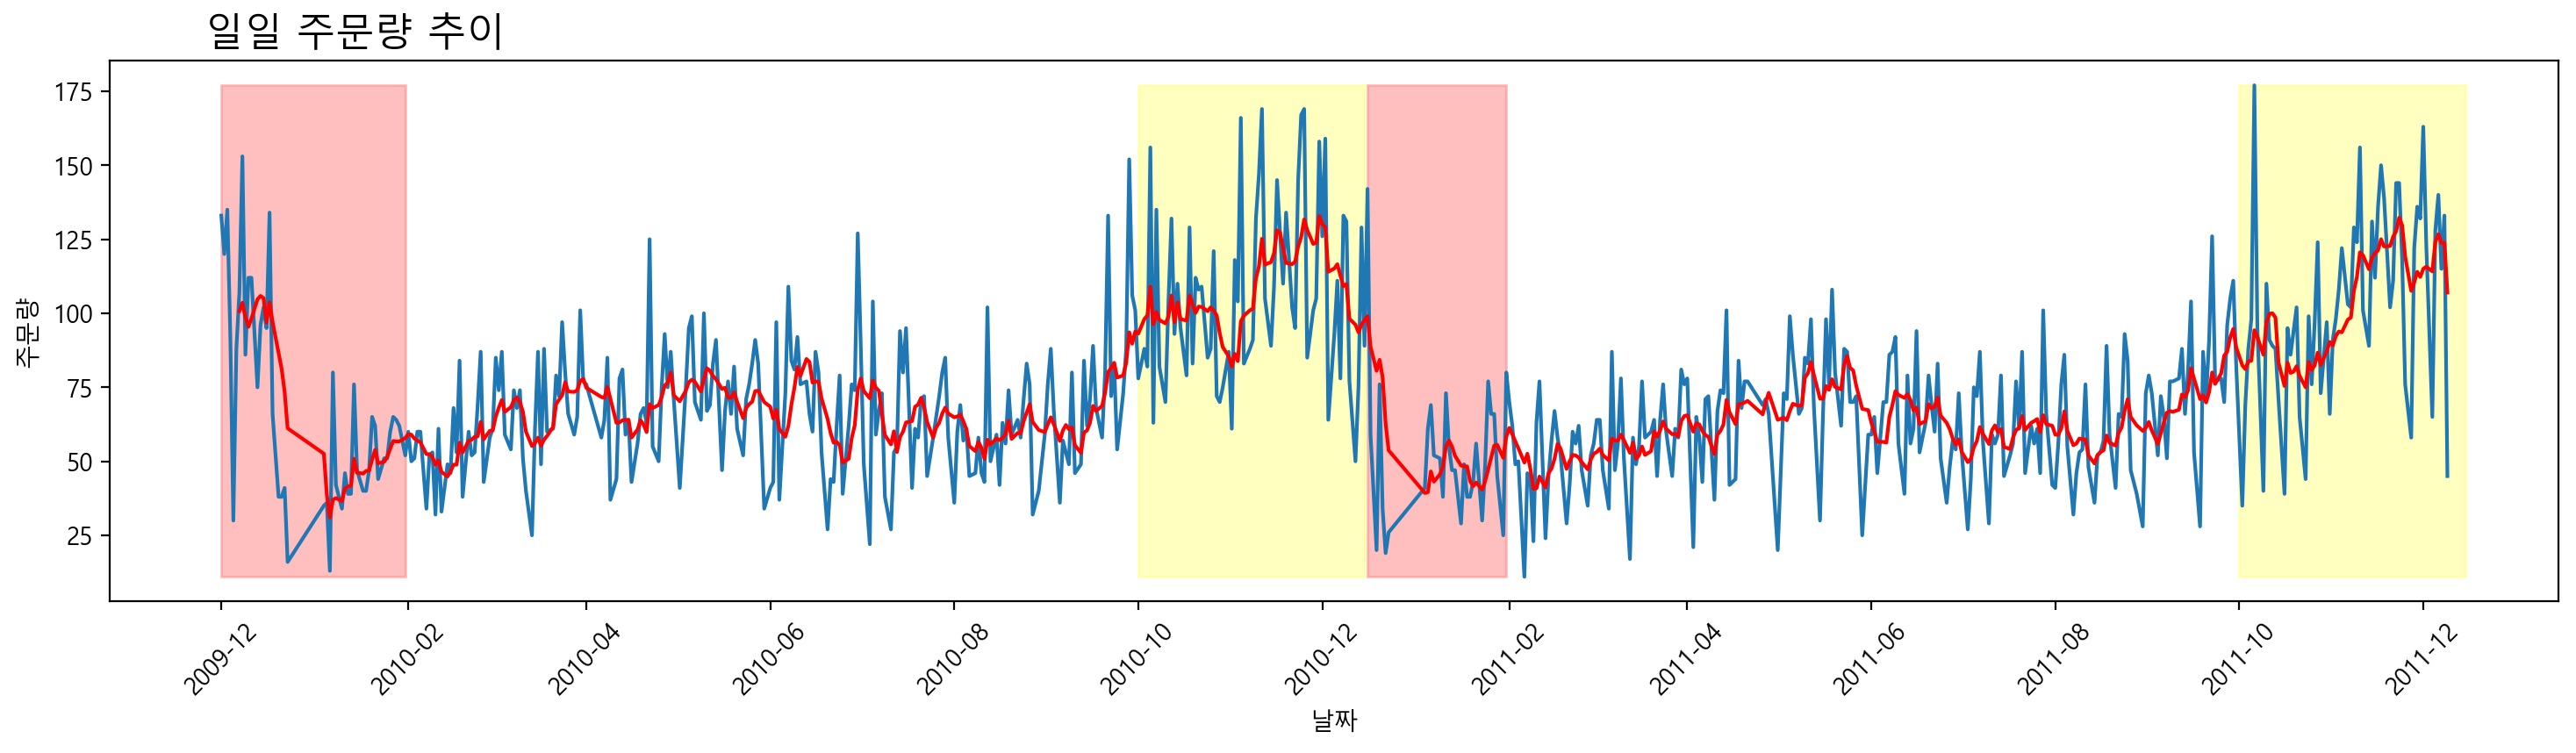

In [76]:
fig, ax = plt.subplots(figsize = (18, 4))

_ = sns.lineplot(x=daily_cnt.index, y=daily_cnt.values)
_ = sns.lineplot(x=daily_cnt.index, y=daily_cnt_smooth.values, color='red')

# 눈금을 2개월에 하나씩 표시되도록 설정
import matplotlib.dates as mdates
_ = plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
_ = plt.xticks(rotation=45)

_ = plt.xlabel('날짜')
_ = plt.ylabel('주문량')
_ = plt.title('일일 주문량 추이', fontdict={'fontsize':16}, x=0.1, y=1)

# 특정 구간에 square 그리기
from matplotlib.patches import Rectangle
start_date = datetime.datetime(2010, 10, 1)
end_date = datetime.datetime(2010, 12, 15)
width = end_date - start_date
height = max(daily_cnt) - min(daily_cnt)
square = Rectangle((start_date, min(daily_cnt)), width, height, fill=True, color=(1, 1, 0.5), alpha=0.5)
_=plt.gca().add_patch(square)

start_date = datetime.datetime(2010, 12, 16)
end_date = datetime.datetime(2011, 1, 31)
width = end_date - start_date
square = Rectangle((start_date, min(daily_cnt)), width, height, fill=True, color=(1, 0.5, 0.5), alpha=0.5)
_=plt.gca().add_patch(square)

start_date = datetime.datetime(2011, 10, 1)
end_date = datetime.datetime(2011, 12, 15)
width = end_date - start_date
square = Rectangle((start_date, min(daily_cnt)), width, height, fill=True, color=(1, 1, 0.5), alpha=0.5)
_=plt.gca().add_patch(square)

start_date = datetime.datetime(2009, 12, 1)
end_date = datetime.datetime(2010, 1, 31)
width = end_date - start_date
square = Rectangle((start_date, min(daily_cnt)), width, height, fill=True, color=(1, 0.5, 0.5), alpha=0.5)
_=plt.gca().add_patch(square)

## 2.2. 요일별 구매 패턴

In [513]:
pattern_df['DayOfWeek'] = pattern_df['InvoiceDate'].dt.day_name()
dayofweek_cnt = pattern_df.groupby('DayOfWeek', as_index=False)['Invoice'].nunique()
dayofweek_cnt = dayofweek_cnt.reindex([1, 5, 6, 4, 0, 2, 3]).reset_index(drop=True)

In [514]:
dayofweek_cnt

,DayOfWeek,Invoice
0,Monday,5683
1,Tuesday,6528
2,Wednesday,6597
3,Thursday,7694
4,Friday,5325
5,Saturday,30
6,Sunday,4740


In [516]:
pattern_df[pattern_dfdd['DayOfWeek']=='Saturday']

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,InvoiceDate_day,DayOfWeek
8639,490363,84950,ASSORTED COLOUR T-LIGHT HOLDER,192,2009-12-05 10:11:00,0.7,13199.0,United Kingdom,2009-12-05,Saturday
8640,490364,48185,DOOR MAT FAIRY CAKE,4,2009-12-05 10:25:00,6.8,13487.0,United Kingdom,2009-12-05,Saturday
8641,490364,84836,ZINC METAL HEART DECORATION,12,2009-12-05 10:25:00,1.2,13487.0,United Kingdom,2009-12-05,Saturday
8642,490364,22415,WHITE TISSUE REAM,1,2009-12-05 10:25:00,8.0,13487.0,United Kingdom,2009-12-05,Saturday
8643,490364,48187,DOOR MAT NEW ENGLAND,4,2009-12-05 10:25:00,6.8,13487.0,United Kingdom,2009-12-05,Saturday
...,...,...,...,...,...,...,...,...,...,...
9034,490394,21955,UNION JACK GUNS & ROSES DOORMAT,6,2009-12-05 16:01:00,6.0,17850.0,United Kingdom,2009-12-05,Saturday
9035,490394,85014A,BLACK/BLUE DOTS RUFFLED UMBRELLA,12,2009-12-05 16:01:00,5.0,17850.0,United Kingdom,2009-12-05,Saturday
9036,490394,15056N,EDWARDIAN PARASOL NATURAL,12,2009-12-05 16:01:00,5.0,17850.0,United Kingdom,2009-12-05,Saturday
9037,490394,20679,EDWARDIAN PARASOL RED,12,2009-12-05 16:01:00,5.0,17850.0,United Kingdom,2009-12-05,Saturday


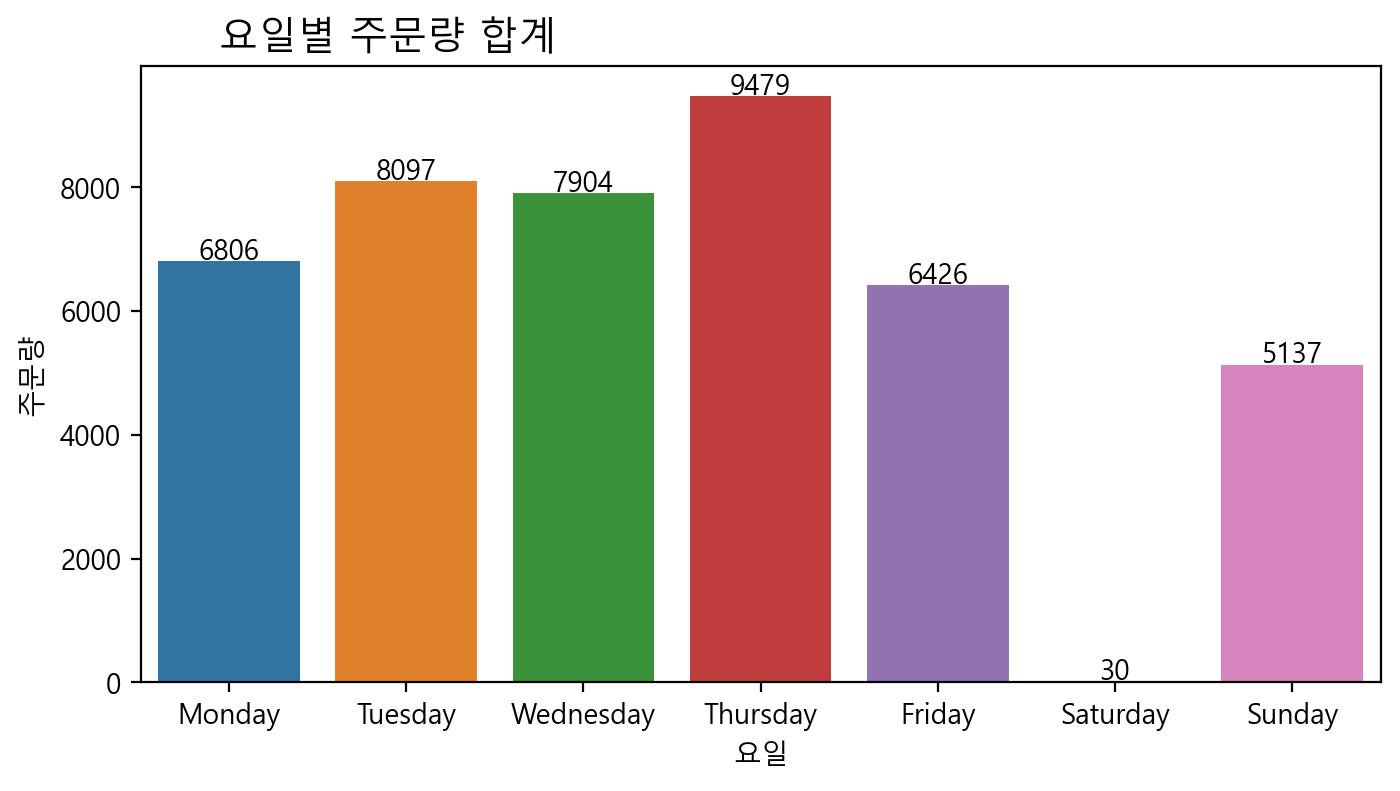

In [170]:
fig, ax = plt.subplots(figsize=(8,4))

_ = sns.barplot(x=dayofweek_cnt['DayOfWeek'], y=dayofweek_cnt['Invoice'])

_ = plt.xlabel('요일')
_ = plt.ylabel('주문량')
_ = plt.title('요일별 주문량 합계', fontdict={'fontsize':14}, x=0.2, y=1)

for index, row in dayofweek_cnt.iterrows():
    _ = ax.text(x=index, y=row['Invoice']+20, s=row['Invoice'], ha='center')

## 2.3. 시간대별 구매 패턴

In [51]:
pattern_df['Hour'] = pattern_df['InvoiceDate'].dt.hour
hour_cnt = pattern_df.groupby('Hour')['Invoice'].nunique()

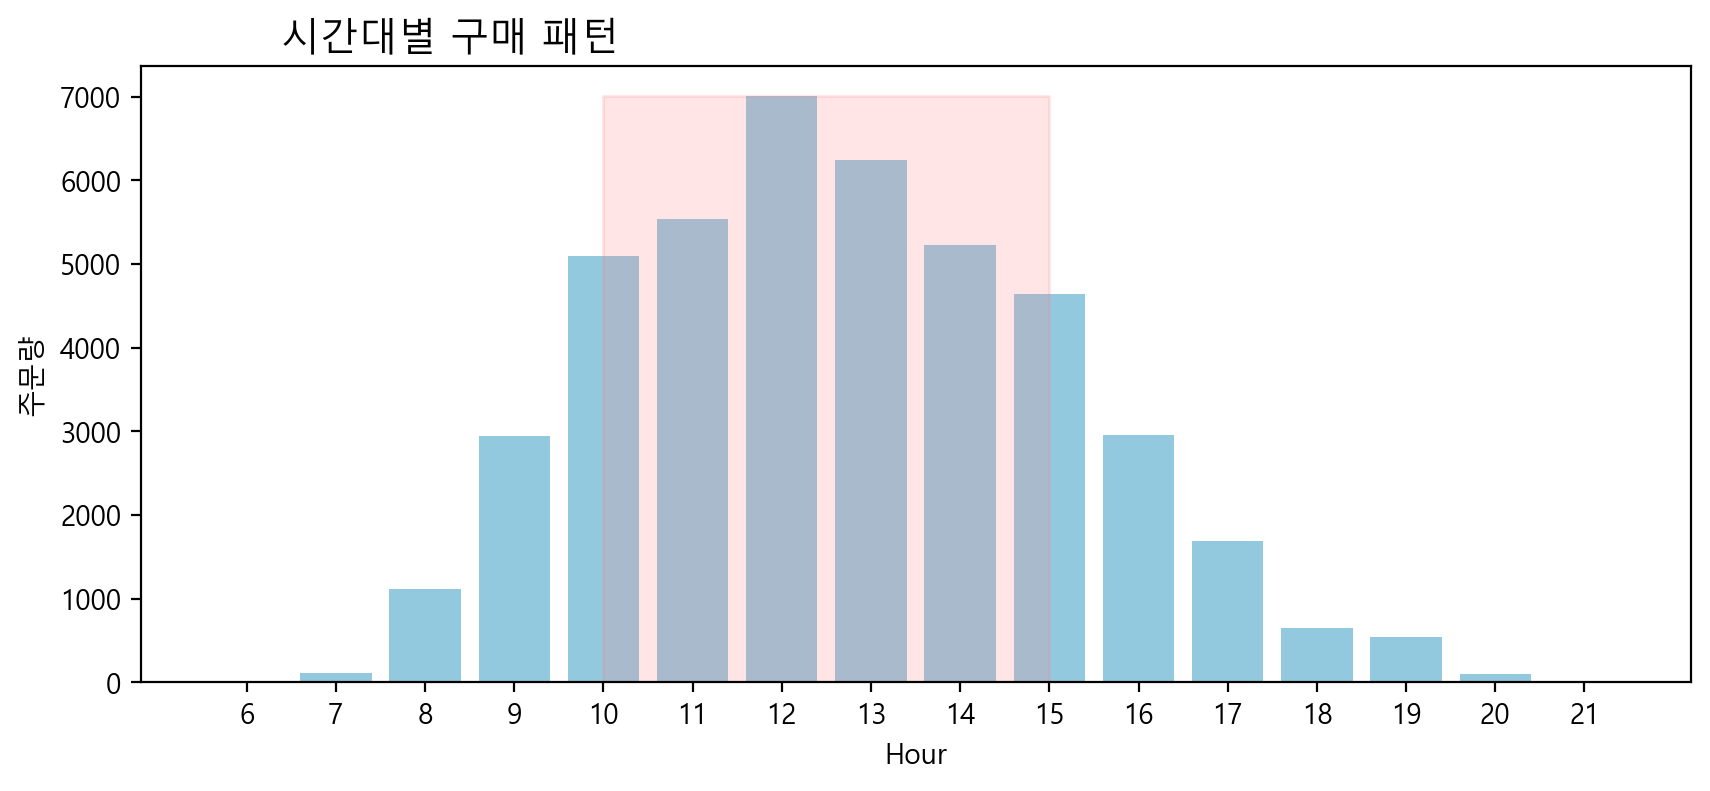

In [117]:
fig, ax = plt.subplots(figsize=(10, 4))

_ = sns.barplot(x=hour_cnt.index, y=hour_cnt, color='skyblue')

# rectangular area 그리기
_ = plt.fill_between(range(10-6, 16-6), 0, max(hour_cnt), color=(1, 0.5, 0.5), alpha=0.2)

_ = plt.ylabel('주문량')
_ = plt.title('시간대별 구매 패턴', fontdict={'fontsize':14}, x=0.2)

# 3. 해외 시장 분석

## 3.1. 해외 판매 추이

In [13]:
pattern_df['Year'] = pattern_df['InvoiceDate'].dt.strftime('%Y')
country_cnt = pattern_df.groupby(['Year', 'Country'], as_index=False)['Invoice'].nunique()
country_cnt = country_cnt.sort_values(['Year', 'Invoice'], ascending=[True, False])
country_cnt = country_cnt[(country_cnt['Year'] != '2009') & (country_cnt['Country'] != 'United Kingdom')]

In [86]:
country_cnt_t10 = country_cnt.groupby('Year').apply(lambda x: x.nlargest(10, 'Invoice')).reset_index(drop=True)

country_cnt_t10_2010 = country_cnt_t10[country_cnt_t10['Year']=='2010'].reset_index(drop=True)
country_cnt_t10_2011 = country_cnt_t10[country_cnt_t10['Year']=='2011'].reset_index(drop=True)

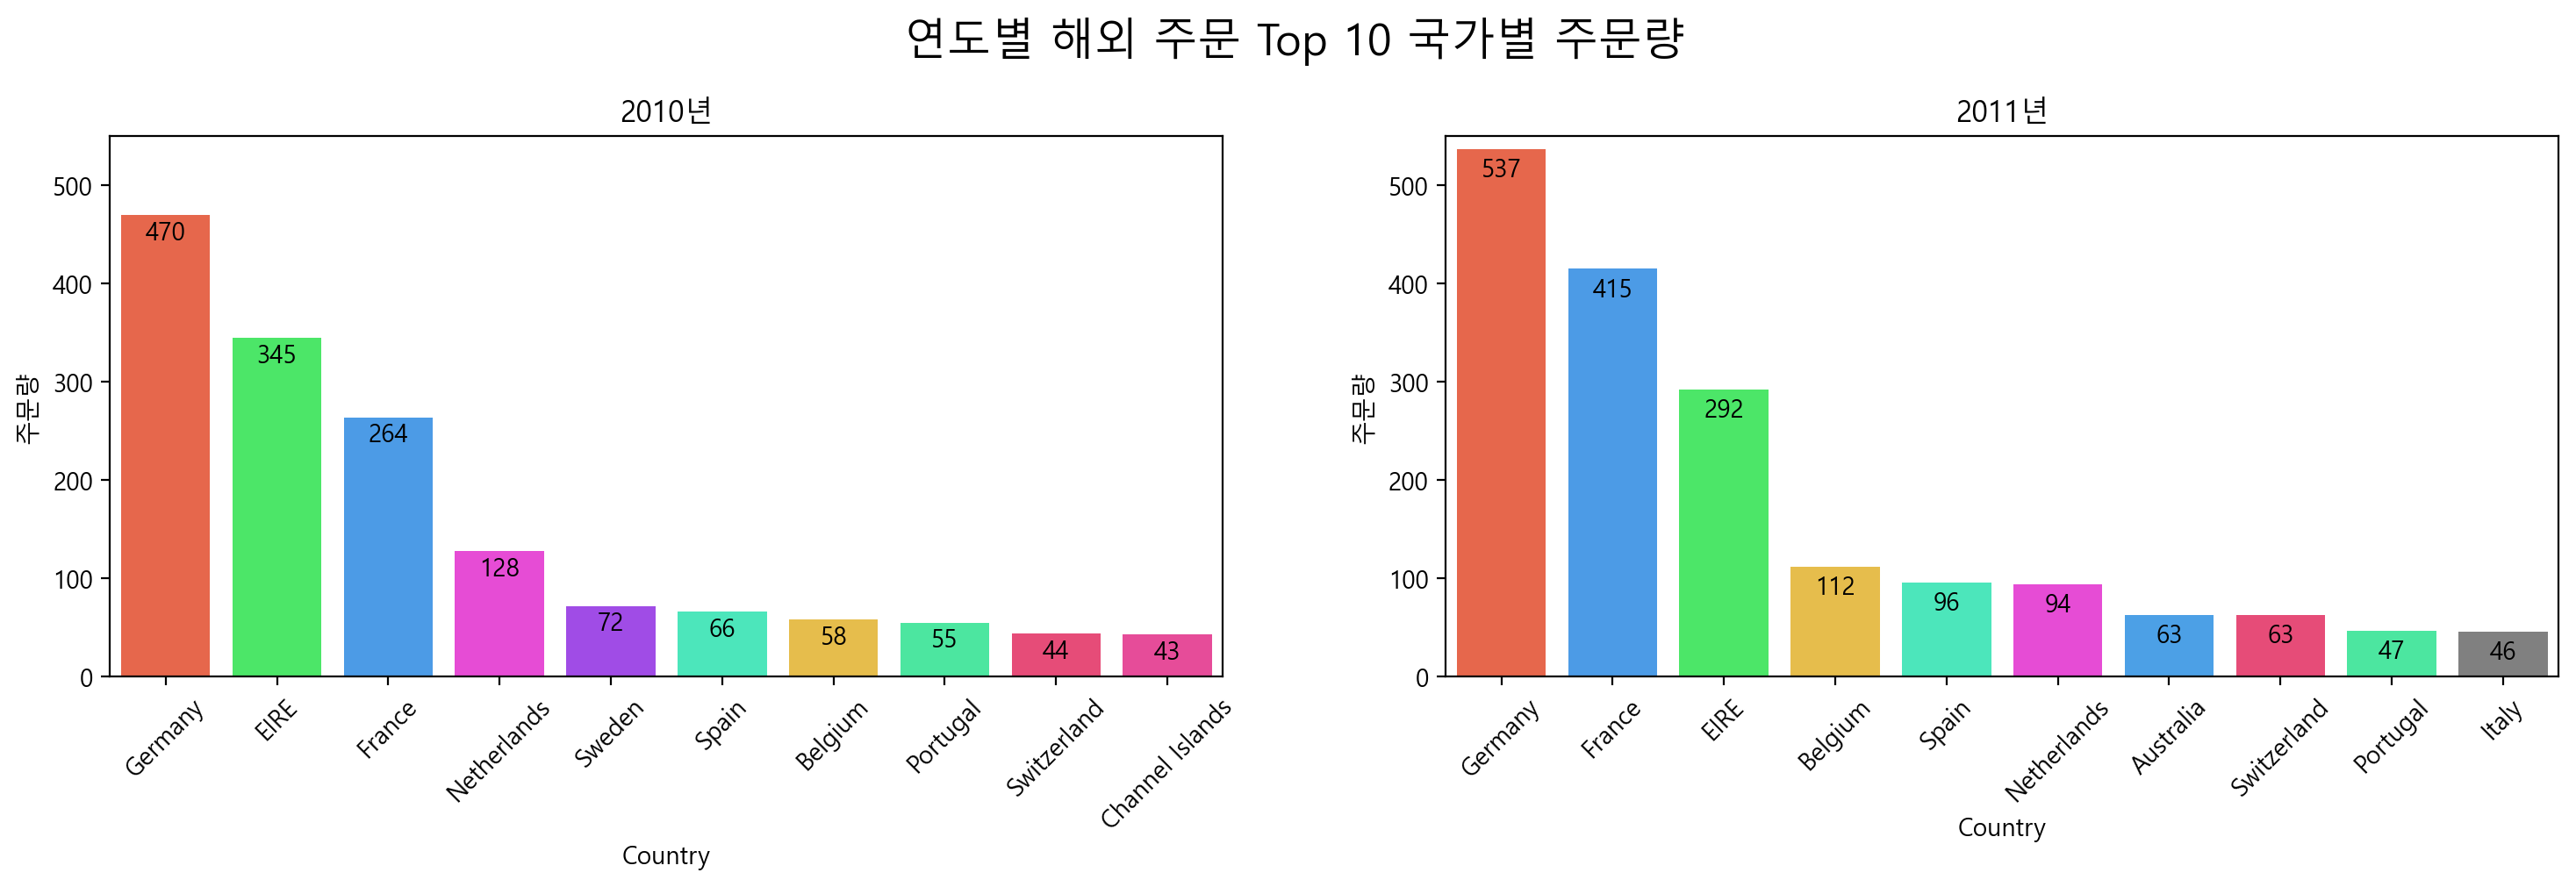

In [158]:
fig, ax = plt.subplots(1, 2, figsize = (18, 4))

## ax[0]
_ = sns.barplot(x=country_cnt_t10_2010['Country'], y=country_cnt_t10_2010['Invoice'], ax=ax[0],
               palette=["#FF5733", "#33FF57", "#339CFF", "#FF33E9", "#A233FF", "#33FFC6", "#FFC933", "#33FFA2", "#FF336D", "#FF3399"])
# x축 레이블 회전
_ = ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
# y축 범위
_ = ax[0].set_ylim(0, 550)
# y축 레이블
_ = ax[0].set_ylabel('주문량')
# 텍스트 추가
for index, row in country_cnt_t10_2010.iterrows():
    _ = ax[0].text(x=index, y=row['Invoice']-25, s=row['Invoice'], ha='center')
    

## ax[1]
_ = sns.barplot(x=country_cnt_t10_2011['Country'], y=country_cnt_t10_2011['Invoice'], ax=ax[1],
               palette=["#FF5733", "#339CFF", "#33FF57", "#FFC933", "#33FFC6", "#FF33E9", "#33A2FF", "#FF336D", "#33FFA2", "gray"])
# x축 레이블 회전
_ = ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)
# y축 범위
_ = ax[1].set_ylim(0, 550)
# y축 레이블
_ = ax[1].set_ylabel('주문량')
# 텍스트 추가
for index, row in country_cnt_t10_2011.iterrows():
    _ = ax[1].text(x=index, y=row['Invoice']-28, s=row['Invoice'], ha='center')
    
## 타이틀 설정
_ = fig.suptitle('연도별 해외 주문 Top 10 국가별 주문량', fontsize=18, y=1.05)
_ = ax[0].set_title('2010년')
_ = ax[1].set_title('2011년')

## 3.2. 연도별 해외 판매량 비중 변화

In [40]:
pattern_df['Country2'] = np.where(pattern_df['Country'] == 'United Kingdom', 'Domestic', 'Overseas')

In [41]:
country_cnt2 = pattern_df.groupby(['Year', 'Country2'], as_index=False)['Invoice'].nunique()
country_cnt2 = country_cnt2.sort_values(['Year', 'Invoice'], ascending=[True, False])
country_cnt2 = country_cnt2[country_cnt2['Year'] != '2009']

country_cnt2_pivot = country_cnt2.pivot_table(index='Year', columns='Country2', values='Invoice', aggfunc='sum', fill_value=0)

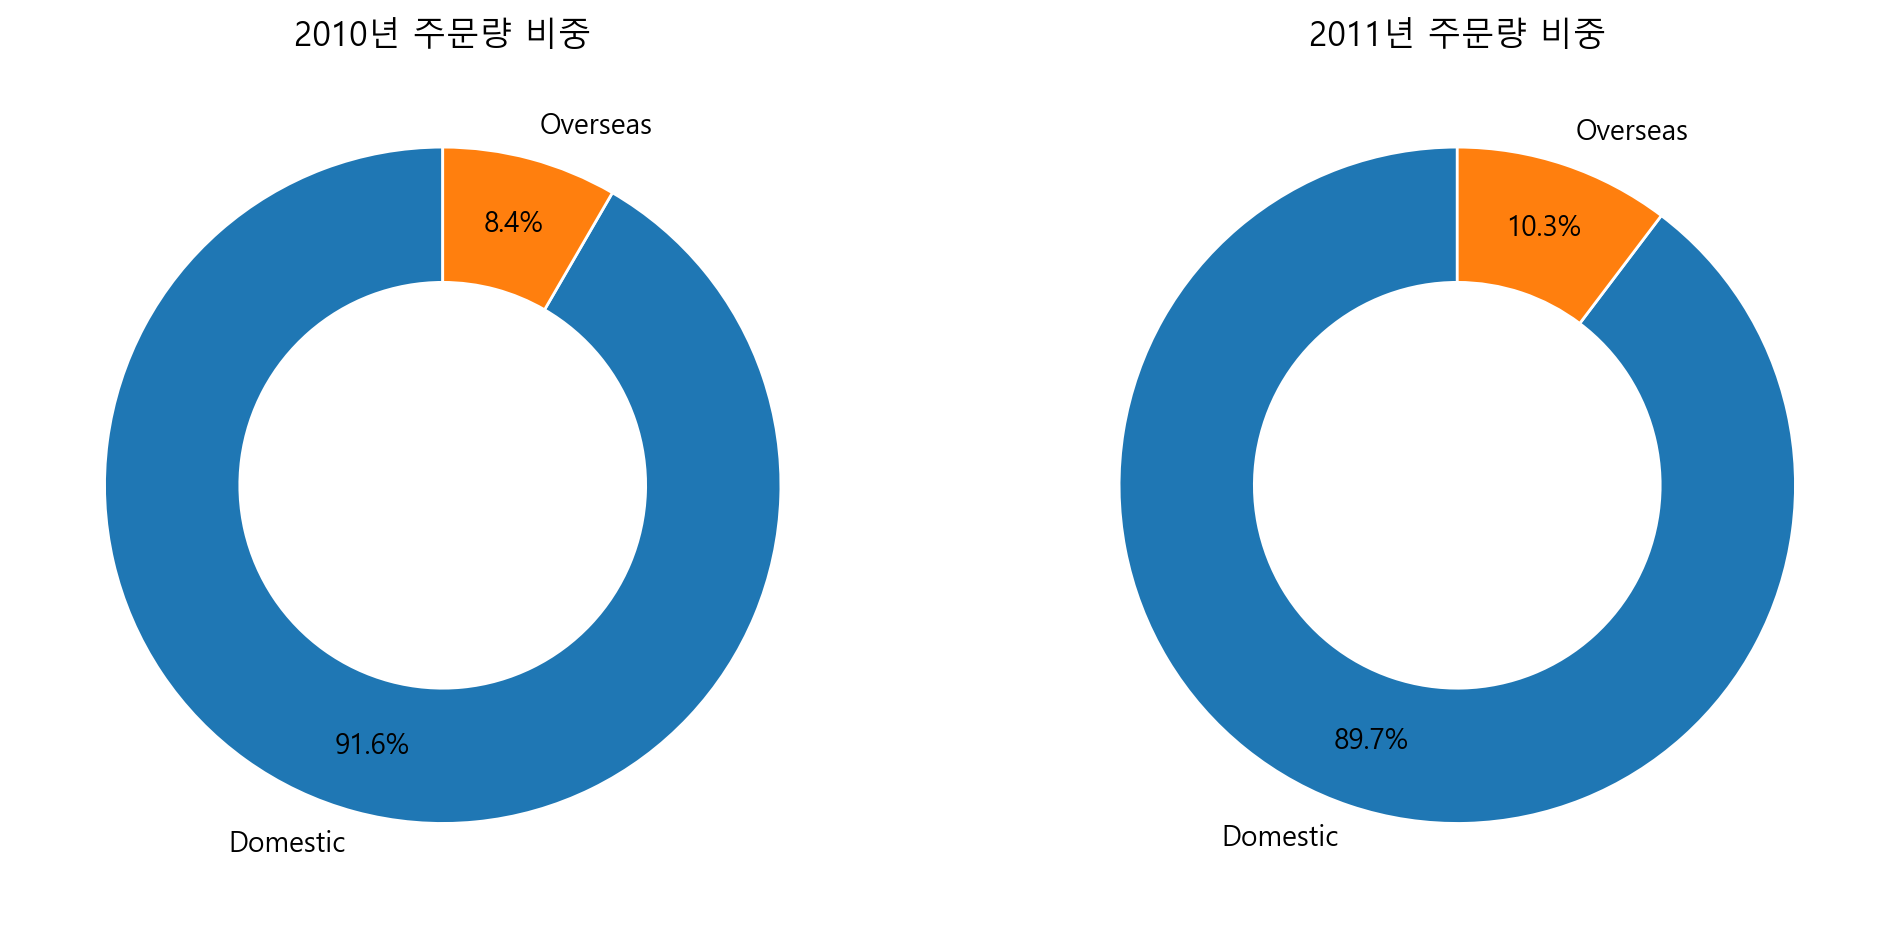

In [87]:
# 두 개의 도넛 차트 그리기
_ = plt.figure(figsize=(12, 6))

# 2010년 도넛 차트
_ = plt.subplot(1, 2, 1)
_ = plt.pie(country_cnt2_pivot.loc['2010'], labels=country_cnt2_pivot.columns, autopct='%1.1f%%', startangle=90, pctdistance=0.8,
        wedgeprops=dict(width=0.4, edgecolor='w'))
_ = plt.title('2010년 주문량 비중')

# 2011년 도넛 차트
_ = plt.subplot(1, 2, 2)
_ = plt.pie(country_cnt2_pivot.loc['2011'], labels=country_cnt2_pivot.columns, autopct='%1.1f%%', startangle=90, pctdistance=0.8,
        wedgeprops=dict(width=0.4, edgecolor='w'))
_ = plt.title('2011년 주문량 비중')

# 4. 아이템 태깅: Color

In [480]:
from nltk import word_tokenize

In [481]:
tagging = retail.copy()
tagging['InvoiceDate'] = pd.to_datetime(tagging['InvoiceDate'])
tagging['InvoiceDate_day'] = tagging['InvoiceDate'].dt.date

- 제품명(Description)을 전처리 후 토큰화(Tokenization)
- 제품별 Top 20 색상(인터넷 서치)에 중 해당하는 색상 이름을 추출

In [482]:
# 소문자로 변환
descrpt = tagging['Description'].str.lower()

# 토큰화
descrpt_token = descrpt.apply(lambda x: word_tokenize(x))

# 색상 이름
color_pattern = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'pink', 'brown', 'black', 'white', 'ivory', 'gray', 'silver', 'gold', 'indigo', 'beige', 'cyan', 'olive', 'coral', 'peach', 'mint', 'charcoal']

In [483]:
def finding_color(token_list, color_pattern):
    matching_colors = [token for token in token_list if token in color_pattern]
    return matching_colors[0] if matching_colors else np.nan

tagging['color'] = descrpt_token.apply(lambda x: finding_color(x, color_pattern))

- 시기별 색상의 트렌드 시각화

In [484]:
# 'quarter_date' 열 추가
tagging['year'] = tagging['InvoiceDate'].dt.year

In [485]:
color_tag = tagging[tagging['color'].isin(color_pattern)]
color_tag = color_tag[color_tag['year'] != 2009].reset_index(drop=True)

In [486]:
# 주요 컬러 확인
main_colors = color_tag['color'].value_counts()[:8].keys()

# 주요 컬러에 속하지 않는 컬러는 Others로 분류
color_tag['color_main'] = np.where(~color_tag['color'].isin(main_colors), 'Others', color_tag['color'])

In [488]:
color_tag[color_tag['color_main'] != 'Others'][['Invoice', 'Description', 'color']]

,Invoice,Description,color
1,493427,WOOD 2 DRAWER CABINET WHITE FINISH,white
2,493427,WHITE ROUND PORCELAIN TLIGHT HOLDER,white
3,493427,BLACK FLOWER CANDLE PLATE,black
4,493427,BLACK SILOUETTE CANDLE PLATE,black
5,493427,CANDLE PLATE LACE WHITE,white
...,...,...,...
210119,581586,DOORMAT RED RETROSPOT,red
210120,581587,ALARM CLOCK BAKELIKE PINK,pink
210121,581587,ALARM CLOCK BAKELIKE RED,red
210122,581587,ALARM CLOCK BAKELIKE GREEN,green


In [489]:
# 'color_trend' 데이터프레임 생성
color_trend = color_tag.groupby('year', as_index=False)['color_main'].value_counts()
color_trend2 = color_trend.pivot_table(index='year', columns='color_main', values='count', aggfunc='sum', fill_value=0)

In [490]:
# color를 크기 순으로 정렬
color_sort2010 = color_trend2.loc[2010].sort_values(ascending=False).keys().tolist()
color_sort2010.remove('Others')
color_sort2010.append('Others')
color_trend2010 = color_trend2.loc[[2010]][color_sort2010]

color_sort2011 = color_trend2.loc[2011].sort_values(ascending=False).keys().tolist()
color_sort2011.remove('Others')
color_sort2011.append('Others')
color_trend2011 = color_trend2.loc[[2011]][color_sort2011]

In [491]:
from colour import Color

red= Color('red')
list(red.range_to(Color('white'), 10))

white= Color('gray')
list(white.range_to(Color('white'), 10))

blue= Color('blue')
list(blue.range_to(Color('white'), 10))

black= Color('black')
list(black.range_to(Color('white'), 10))

green= Color('green')
list(green.range_to(Color('white'), 10))

silver= Color('silver')
list(silver.range_to(Color('white'), 10))

ivory= Color('ivory')
list(ivory.range_to(Color('yellow'), 10))

[<Color red>,
 <Color #f22929>,
 <Color #e94f4f>,
 <Color #e37171>,
 <Color #e09191>,
 <Color #e0adad>,
 <Color #e3c6c6>,
 <Color #e9dcdc>,
 <Color #f2efef>,
 <Color white>]

[<Color gray>,
 <Color #8e8e8e>,
 <Color #9c9c9c>,
 <Color #aaa>,
 <Color #b8b8b8>,
 <Color #c7c7c7>,
 <Color #d5d5d5>,
 <Color #e3e3e3>,
 <Color #f1f1f1>,
 <Color white>]

[<Color blue>,
 <Color #2982f2>,
 <Color #4fd8e9>,
 <Color #71e3bd>,
 <Color #91e0a2>,
 <Color #b8e0ad>,
 <Color #d9e3c6>,
 <Color #e9e8dc>,
 <Color #f2f1ef>,
 <Color white>]

[<Color black>,
 <Color #1c1c1c>,
 <Color #393939>,
 <Color #555>,
 <Color #717171>,
 <Color #8e8e8e>,
 <Color #aaa>,
 <Color #c6c6c6>,
 <Color #e3e3e3>,
 <Color white>]

[<Color green>,
 <Color #2ba109>,
 <Color #61bd18>,
 <Color #9cd52b>,
 <Color #c3d05a>,
 <Color #d0c784>,
 <Color #d5c6aa>,
 <Color #ded4cb>,
 <Color #ece8e7>,
 <Color white>]

[<Color silver>,
 <Color #c7c7c7>,
 <Color #cecece>,
 <Color #d5d5d5>,
 <Color gainsboro>,
 <Color #e3e3e3>,
 <Color #eaeaea>,
 <Color #f1f1f1>,
 <Color #f8f8f8>,
 <Color white>]

[<Color ivory>,
 <Color #ffffd5>,
 <Color #ffb>,
 <Color #ffffa0>,
 <Color #ffff85>,
 <Color #ffff6b>,
 <Color #ffff50>,
 <Color #ffff35>,
 <Color #ffff1b>,
 <Color yellow>]

In [492]:
# 컬러 매핑 딕셔너리
color_mapping = {'red':'#f22929',
                    'pink':'pink',
                    'white':'#f1f1f1',
                    'blue':'#4fd8e9',
                    'black':'#555',
                    'green':'#61bd18',
                    'silver':'#e3e3e3',
                    'ivory':'#ffff6b',
                    'Others':'gray'}

# 각 레이블에 알맞는 색상 리스트 생성
colors2010 = [color_mapping.get(label, 'gray') for label in color_trend2010.columns]
colors2011 = [color_mapping.get(label, 'gray') for label in color_trend2011.columns]

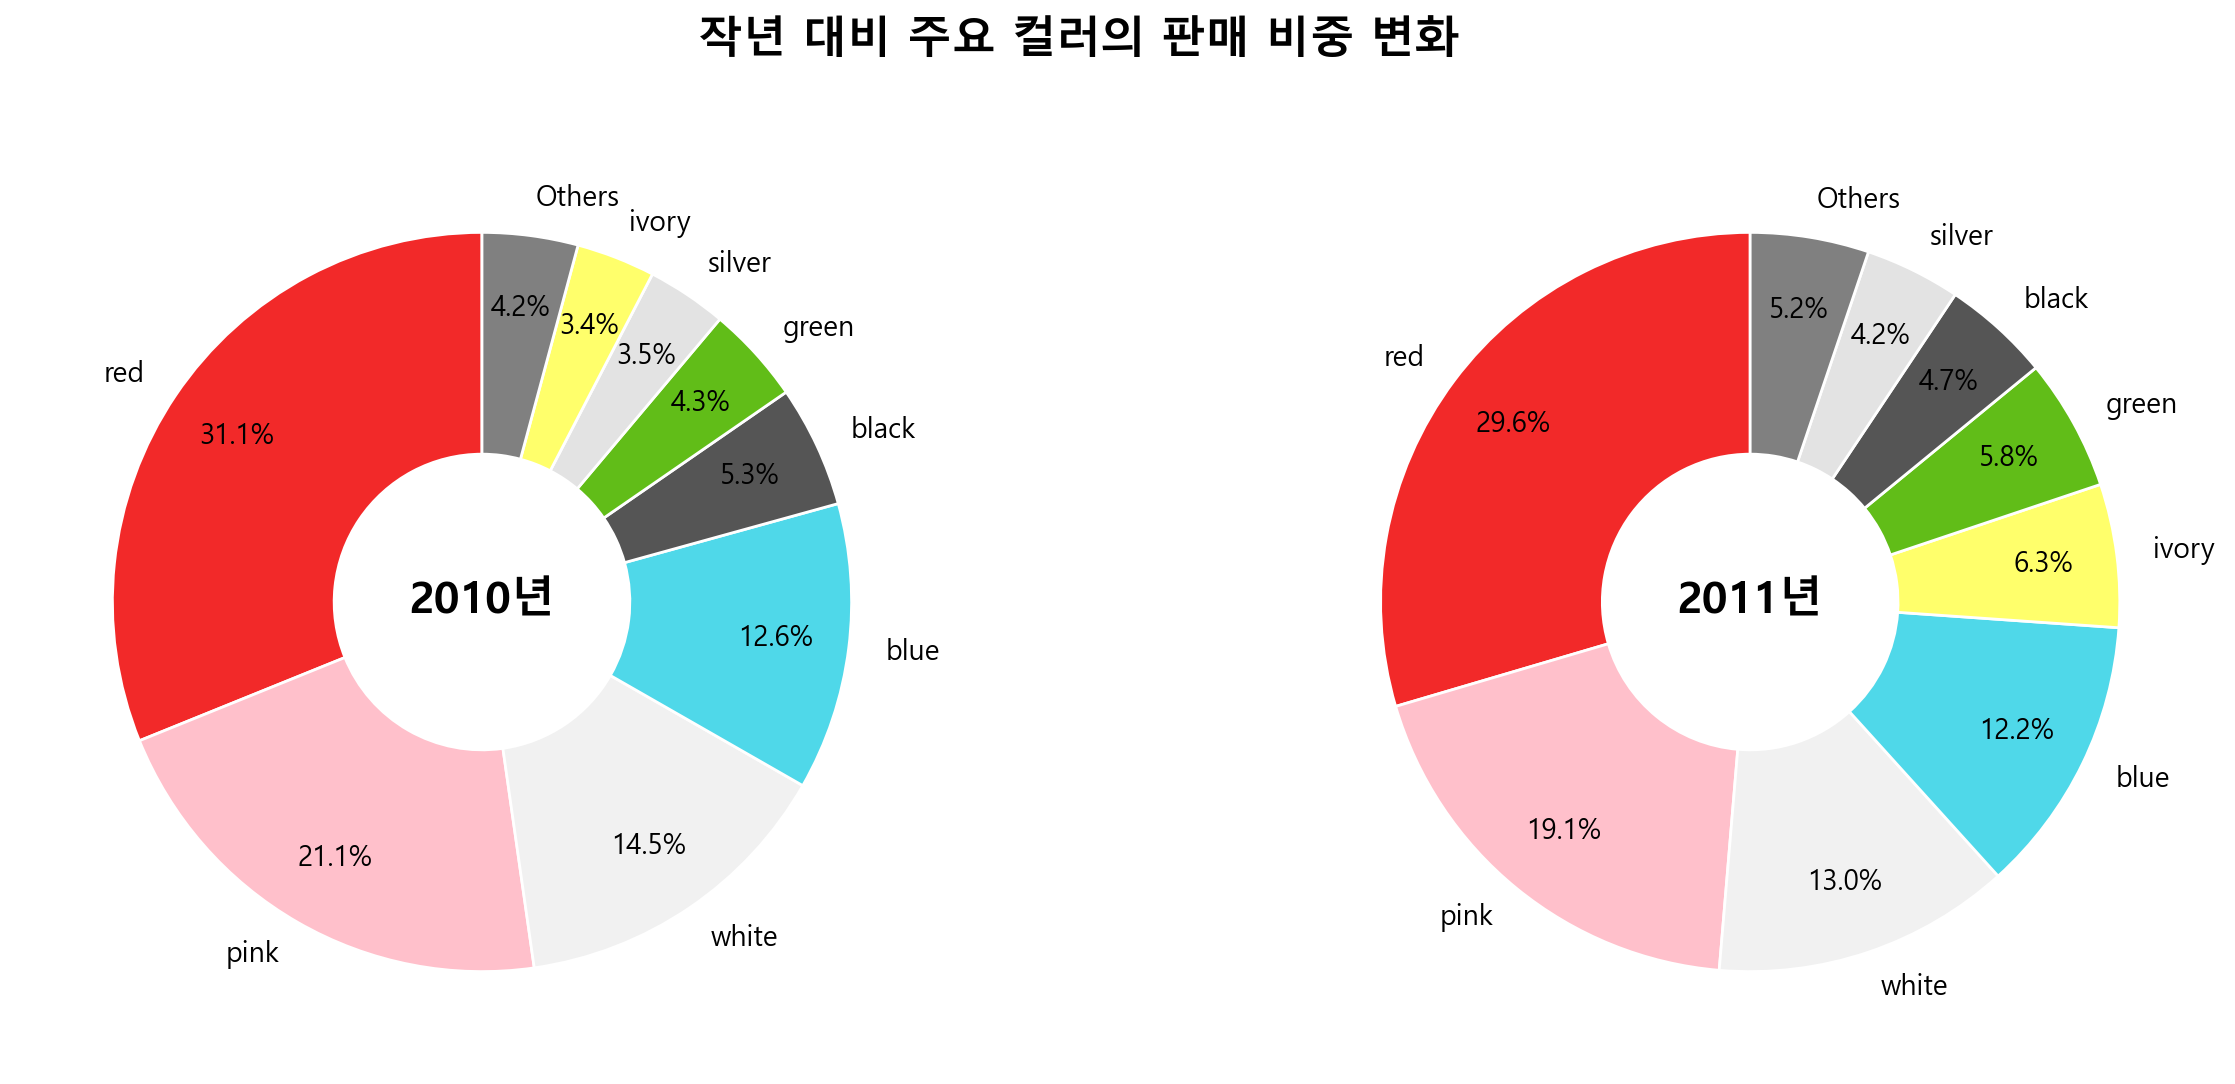

In [497]:
_ = plt.figure(figsize=(15, 6))

# 2010년 파이차트
_ = plt.subplot(1, 2, 1)
_ = plt.pie(color_trend2010.loc[2010], labels=color_trend2010.columns, autopct='%1.1f%%', startangle=90, pctdistance=0.8, colors=colors2010,
           wedgeprops=dict(width=0.6, edgecolor='white'))
# 중앙에 텍스트 추가
_ = center_text = "2010년"
_ = plt.text(0, 0, center_text, ha='center', va='center', fontsize=16, fontweight='bold', color='black')


# 2011년 파이차트
_ = plt.subplot(1, 2, 2)
_ = plt.pie(color_trend2011.loc[2011], labels=color_trend2011.columns, autopct='%1.1f%%', startangle=90, pctdistance=0.8, colors=colors2011,
           wedgeprops=dict(width=0.6, edgecolor='white'))
# 중앙에 텍스트 추가
_ = center_text = "2011년"
_ = plt.text(0, 0, center_text, ha='center', va='center', fontsize=16, fontweight='bold', color='black')

# 타이틀
_ = plt.suptitle('작년 대비 주요 컬러의 판매 비중 변화', fontsize=16, fontweight='bold')

# 5. RFM Segmentation을 통한 고객 분석

## 5.1. RFM Segmentation

- 분석 데이터를 2011년 3월 31일을 기준으로 1) 평가 데이터와 2) 관찰데이터로 구분
    - 분석 자격 대상자는 2010년 3월 31일 기준으로 그 전까지 한번이라도 구매 이력이 있는 자
    - RFM 군집 분석은 2010년 3월 부터 2011년 2월까지의 구매 이력을 바탕으로 수행하며, 2011년 3월 이후의 구매 데이터를 바탕으로 해당 군집의 유효성을 검증하고자 함 
    - 이는 정확한 분석을 위하여 분석 기간에 새롭게 유입되는 고객은 배제하고 기존 고객들만을 대상으로 분석하고자 하기 위함

In [326]:
rfm_df = retail.copy()
rfm_df['InvoiceDate'] = pd.to_datetime(pd.to_datetime(rfm_df['InvoiceDate']).dt.date)

# 구매수량 x 단가 를 이용하여 구매 금액 계산
rfm_df['TotalSum'] = rfm_df['Quantity'] * rfm_df['Price']

In [327]:
# 분석대상 고객 ID 추출
tmp = rfm_df.groupby('Customer ID', as_index=False)['InvoiceDate'].agg(['min', 'max'])
tmp = tmp[(tmp['min'] <= '2010-03-31') & (tmp['max'] > '2010-03-31')]
elig_ids = tmp['Customer ID']

# 분석대상 고객의 구매 데이터만 추출
rfm_df2 = rfm_df[rfm_df['Customer ID'].isin(elig_ids)].reset_index(drop=True)

In [246]:
# Train dataset
train_rfm = rfm_df2[(rfm_df2['InvoiceDate']>='2010-03-01') & (rfm_df2['InvoiceDate']<'2011-03-01')].reset_index(drop=True)

# Test dataset
test_rfm = rfm_df2[rfm_df2['InvoiceDate']>='2011-03-01'].reset_index(drop=True)

- 분석일(analysis date)은 평가 종료일 다음 날로 설정
- RFM 추출
    - Recency: analysis date로 부터 가장 최근 거래일 까지의 기간 (월 단위)
    - Frequency: 분석 기간 동안 구매 일수
    - Monetary value: 분석 기간 동안 고객이 지불한 총 금액

In [328]:
# analysis date
analysis_date = (train_rfm['InvoiceDate']).max() + datetime.timedelta(days=1)

In [329]:
train_rfm2 = train_rfm.groupby('Customer ID', as_index=False).agg({
    'InvoiceDate':[('Recency', lambda x: round((analysis_date - x.max()).days/30)),
                  ('Frequency', 'nunique')],
    'TotalSum':'sum'
})

train_rfm2.columns = ['Customer ID', 'Recency', 'Frequency', 'Monetary Value']

**Recency** <br>
    - 3개월 이내에 거래시: 3점 <br>
    - 3개월 초과 9개월 이내에 거래O: 2점 <br>
    - 9개월 초과 12개월 이내에 거래O: 1점 <br>
<br>
**Frequency, Monetary value** <br>
    - 상위 20%: 5점 <br>
    - 상위 40%: 4점 <br>
    - 상위 60%: 3점 <br>
    - 상위 80%: 2점 <br>
    - 이외: 1점

In [330]:
train_rfm2['R'] = np.select(condlist=[train_rfm2['Recency']<=3, train_rfm2['Recency']<=9], choicelist=[3, 2], default=1)
train_rfm2['F'] = pd.qcut(train_rfm2['Frequency'], q=5, labels=[1, 2, 3, 4, 5])
train_rfm2['M'] = pd.qcut(train_rfm2['Monetary Value'], q=5, labels=[1, 2, 3, 4, 5])

train_rfm2['RFM Score'] = train_rfm2['R'].astype(str) + train_rfm2['F'].astype(str) + train_rfm2['M'].astype(str)

출처: https://headset.happyfox.com/kb/article/79-rfm-segmentation/

In [357]:
seg_map = {
    r'355' : 'VIP',
    r'3[4-5][3-5]' : 'Champions',
    r'3[3-5][4-5]' : 'Champions',
    r'3[2-3].' : 'Potential Loyalists',
    r'^3..' : 'Promising',
    r'2[4-5].' : 'Loyal',
    r'23[4-5]' : 'Loyal',
    r'2[1-2].' : 'About_to_sleep',
    r'23.' : 'Need attention',
    r'1\d\d' : 'Hibernating'}

In [366]:
train_rfm2['RFM Seg'] = train_rfm2['RFM Score'].replace(seg_map, regex=True)

In [369]:
train_rfm2

,Customer ID,Recency,Frequency,Monetary Value,R,F,M,RFM Score,RFM Score2,RFM Seg
0,12346.0,1,3,77353.0,3,2,5,325,Potential Loyalists,Potential Loyalists
1,12358.0,3,2,1089.2,3,1,3,313,Promising,Promising
2,12359.0,1,6,4110.9,3,4,5,345,Champions,Champions
3,12360.0,4,2,1192.8,2,1,3,213,About_to_sleep,About_to_sleep
4,12361.0,0,3,357.1,3,2,1,321,Potential Loyalists,Potential Loyalists
...,...,...,...,...,...,...,...,...,...,...
1775,18272.0,9,3,1307.4,2,2,3,223,About_to_sleep,About_to_sleep
1776,18275.0,10,1,369.2,1,1,1,111,Hibernating,Hibernating
1777,18276.0,4,4,1102.6,2,3,3,233,Need attention,Need attention
1778,18283.0,0,7,837.2,3,4,2,342,Promising,Promising


**Snake plot**

Snake plot으로 각 집단별 특성을 시각화 하고자 함


In [397]:
# Recency를 역수화
train_rfm2['Recency_rev'] = train_rfm2['Recency'].replace({0:12, 1:11, 2:10, 3:9, 4:8, 5:7, 7:5, 8:4, 9:3, 10:2, 11:1, 12:0})

# 데이터 정규화
train_mean = train_rfm2[['Recency_rev', 'Frequency', 'Monetary Value']].mean()
train_std = train_rfm2[['Recency_rev', 'Frequency', 'Monetary Value']].std()
train_scale = (train_rfm2[['Recency_rev', 'Frequency', 'Monetary Value']] - train_mean) / train_std
train_scale.columns = ['Recency\nScore', 'Frequency\nScore', 'Monetary Value\nScore']

train_rfm3 = pd.concat([train_rfm2, train_scale], axis=1)

In [398]:
train_melt = pd.melt(train_rfm3, id_vars=['Customer ID', 'RFM Seg'], value_vars=['Recency\nScore', 'Frequency\nScore', 'Monetary Value\nScore'], var_name='속성')

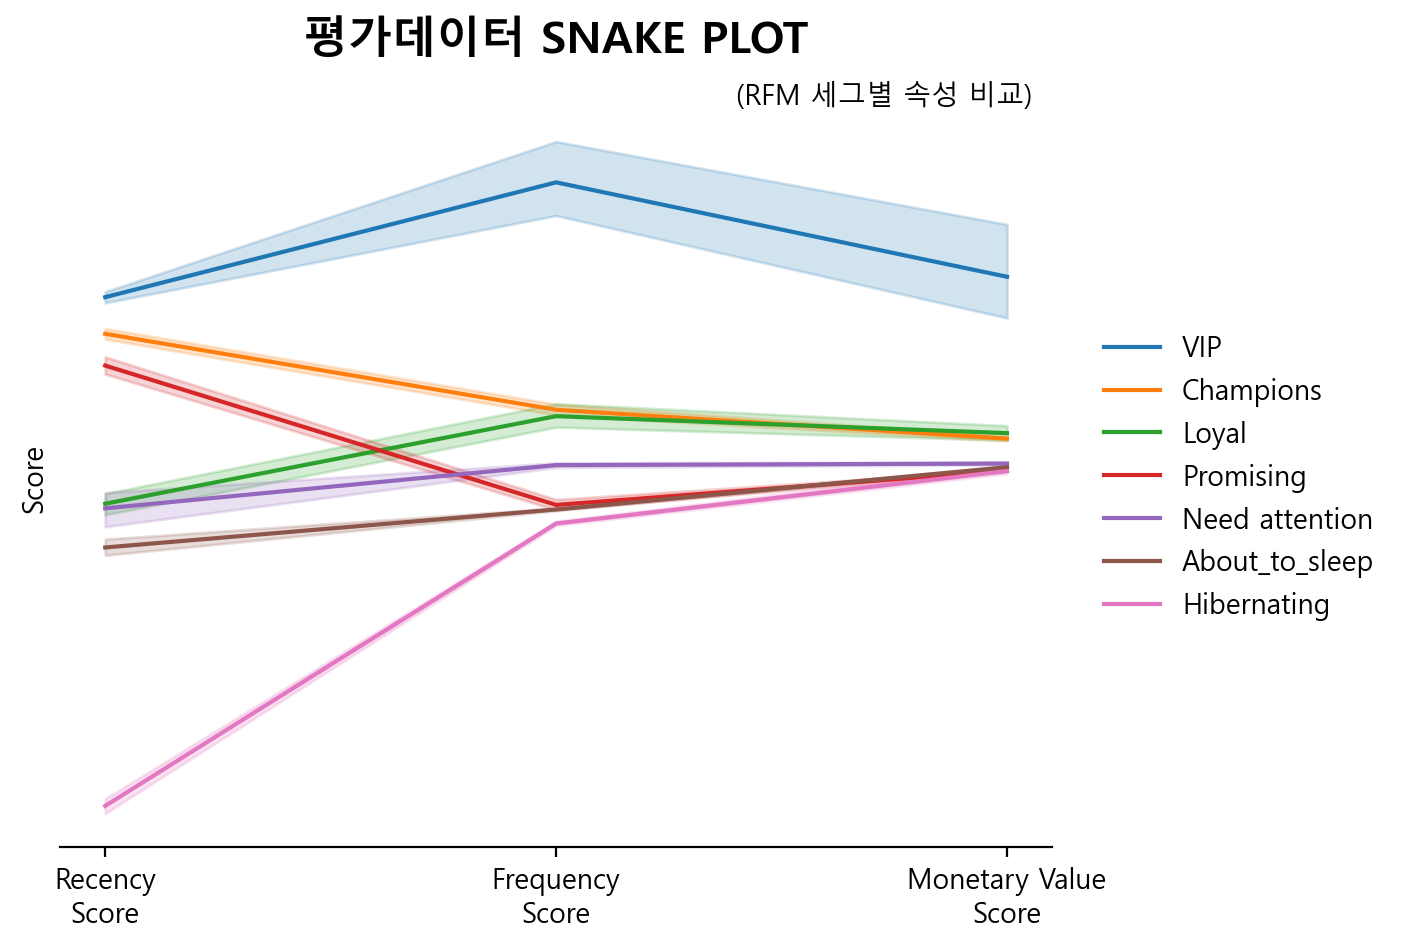

In [517]:
_ = sns.lineplot(x='속성', y='value', hue='RFM Seg', data=train_melt, hue_order=['VIP', 'Champions', 'Loyal', 'Promising', 'Need attention', 'About_to_sleep', 'Hibernating'])

# y축 제거
_ = plt.yticks([])
_ = plt.ylabel('Score')
_ = plt.xlabel('')

# 그래프 라인 제거
_ = plt.gca().spines['top'].set_visible(False)
_ = plt.gca().spines['right'].set_visible(False)
_ = plt.gca().spines['left'].set_visible(False)

# 범례 위치 조정
_ = plt.legend(loc='center right', bbox_to_anchor=(1.35, 0.5), frameon=False)

# 타이틀 제목
_ = plt.title('평가데이터 SNAKE PLOT', fontdict=dict(fontsize=16, fontweight='bold'), pad=20)
_ = plt.text(x=1.4, y=2.2, s='(RFM 세그별 속성 비교)')

## 5.2. RFM 세그먼트 평가

Test set에 대하여 Recency, Frequency, Monetary Value 산출하기

In [468]:
test_rfm2 = test_rfm.merge(train_rfm3[['Customer ID', 'RFM Seg']], on='Customer ID')


analysis_date = test_rfm2['InvoiceDate'].max() + datetime.timedelta(days=1)
test_rfm2 = test_rfm2.groupby(['Customer ID', 'RFM Seg'], as_index=False).agg({
    'InvoiceDate':[('Recency', lambda x: round((analysis_date - x.max()).days/30)),
                   ('Frequency', 'nunique')],
    'TotalSum':'sum'
})

test_rfm2.columns = ['Customer ID', 'RFM Seg', 'Recency', 'Frequency', 'Monetary Value']

Recency, Frequency, Monetary Value 정규화

In [470]:
# Recency를 역수화
test_rfm2['Recency_rev'] = test_rfm2['Recency'].replace({0:12, 1:11, 2:10, 3:9, 4:8, 5:7, 7:5, 8:4, 9:3, 10:2, 11:1, 12:0})

# 데이터 정규화
test_mean = test_rfm2[['Recency_rev', 'Frequency', 'Monetary Value']].mean()
test_std = test_rfm2[['Recency_rev', 'Frequency', 'Monetary Value']].std()
test_scale = (test_rfm2[['Recency_rev', 'Frequency', 'Monetary Value']] - test_mean) / test_std
test_scale.columns = ['Recency\nScore', 'Frequency\nScore', 'Monetary Value\nScore']

test_rfm3 = pd.concat([test_rfm2, test_scale], axis=1)

In [472]:
test_melt = pd.melt(test_rfm3, id_vars=['Customer ID', 'RFM Seg'], value_vars=['Recency\nScore', 'Frequency\nScore', 'Monetary Value\nScore'], var_name='속성')

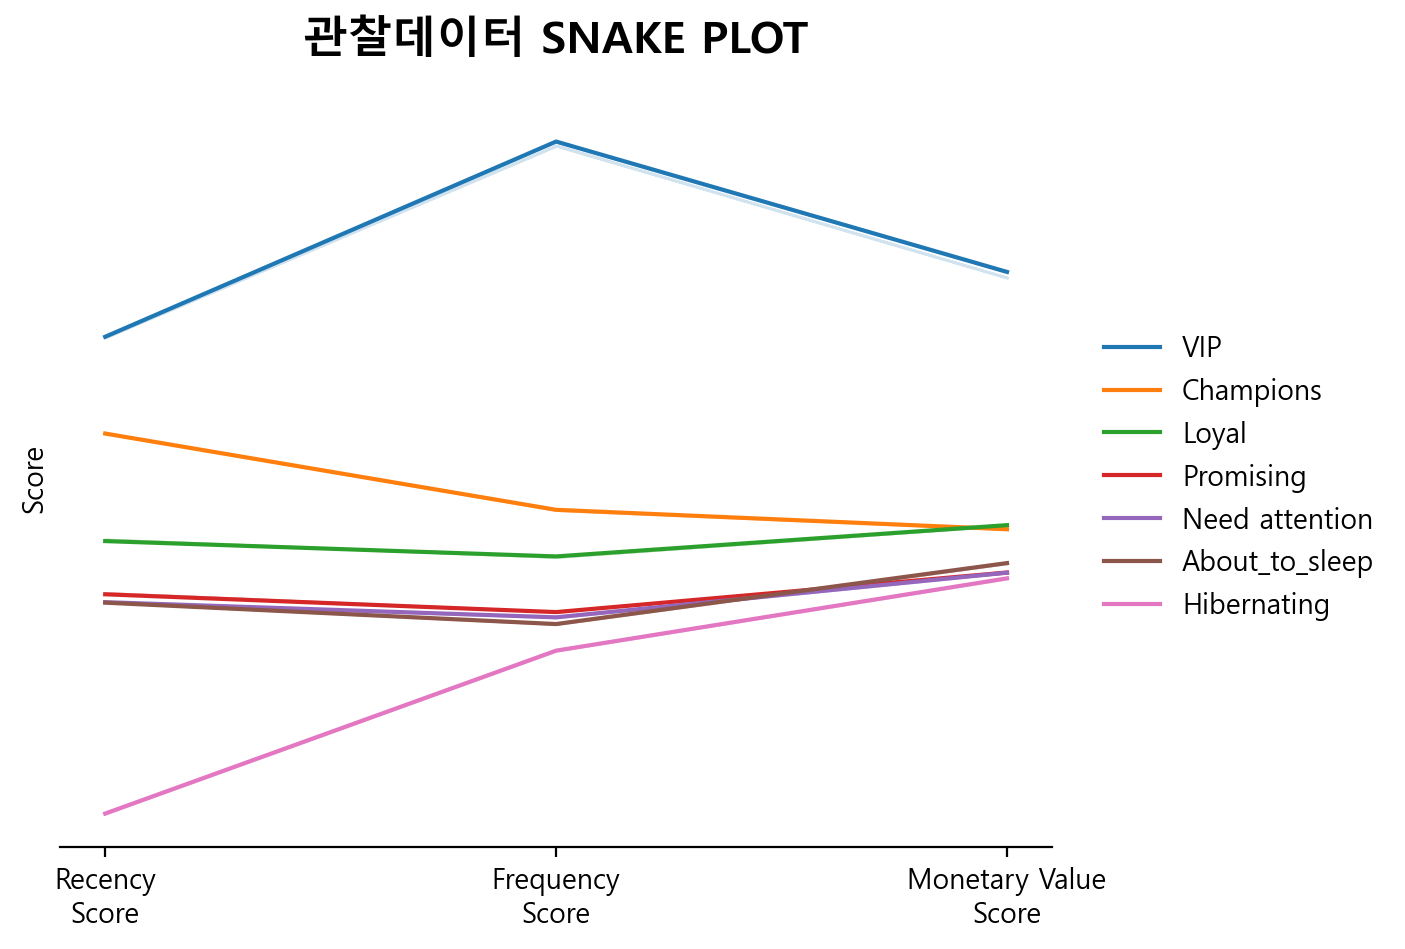

In [518]:
_ = sns.lineplot(x='속성', y='value', hue='RFM Seg', data=test_melt, hue_order=['VIP', 'Champions', 'Loyal', 'Promising', 'Need attention', 'About_to_sleep', 'Hibernating'], ci=False)

# y축 제거
_ = plt.yticks([])
_ = plt.ylabel('Score')
_ = plt.xlabel('')

# 그래프 라인 제거
_ = plt.gca().spines['top'].set_visible(False)
_ = plt.gca().spines['right'].set_visible(False)
_ = plt.gca().spines['left'].set_visible(False)

# 범례 위치 조정
_ = plt.legend(loc='center right', bbox_to_anchor=(1.35, 0.5), frameon=False)

# 타이틀 제목
_ = plt.title('관찰데이터 SNAKE PLOT', fontdict=dict(fontsize=16, fontweight='bold'), pad=20)